## $A \longleftrightarrow 2B \longleftrightarrow C$

1. $A \longrightarrow 2B$

2. $2B \longrightarrow A$

3. $2B \longrightarrow C$

4. $C \longrightarrow 2B$

|  | A | B | C |
|---------------|---|---|---|
|$r_1$|-1|2|0|
|$r_2$|1|-2|0|
|$r_3$|0|-2|1|
|$r_4$|0|2|-1|

In [25]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

Исходные данные

In [26]:
k = np.array([.5, .8, .95, .1])
c = np.array([1, 0, 0])

Матрица стехиометрических коэффициентов

In [27]:
stoich_matrix = np.array([[-1, 2, 0], [1, -2, 0], [0, -2, 1], [0, 2, -1]])
print(stoich_matrix)

[[-1  2  0]
 [ 1 -2  0]
 [ 0 -2  1]
 [ 0  2 -1]]


Нужно выбрать только элементы с отрицательными коэффициентами, для этого создадим массив `mask`:

In [28]:
mask = stoich_matrix < 0
print(mask)

[[ True False False]
 [False  True False]
 [False  True False]
 [False False  True]]


Вычислим произведение элементов `c` в степенях соответствующих стехиометрических коэффициентов для каждой реакции, но только в том случае, если коэффициент < 0 

In [29]:
p = (c ** -(stoich_matrix * mask)).prod(axis=1)
print(p)

[1 0 0 0]


Вычислим скорости реакций

In [30]:
reaction_rates = p * k
print(reaction_rates)

[0.5 0.  0.  0. ]


Правые части дифференциальных уравнений

In [31]:
right_parts = (
    (stoich_matrix.T * reaction_rates).sum(axis=1)
)
print(right_parts)

[-0.5  1.   0. ]


Все то же самое, но в виде функции

In [32]:
def kinetic_by_matrix(
    time: float,
    c: np.ndarray,
    stoich_matrix: np.ndarray,
    k: np.ndarray
) -> np.ndarray:

    mask = stoich_matrix < 0
    p = (c ** -(stoich_matrix * mask)).prod(axis=1)
    reaction_rates = p * k
    
    right_parts = (
        (stoich_matrix.T * reaction_rates).sum(axis=1)
    )
    
    return right_parts

Как это обычно делается

In [33]:
def kin_scheme(
    time: float,
    c: np.ndarray,
    k: np.ndarray
) -> np.ndarray:

    ca, cb, cc = c
    k1, k2, k3, k4 = k

    dca_dt = -k1 * ca + k2 * cb ** 2
    dcb_dt = 2 * (k1 * ca - k2 * cb ** 2 - k3 * cb ** 2 + k4 * cc)
    dcc_dt = k3 * cb ** 2 - k4 * cc

    return dca_dt, dcb_dt, dcc_dt

Проверка

In [34]:
t = np.linspace(0, 10, 20)

In [35]:
sol_matrix = solve_ivp(
    fun=kinetic_by_matrix,
    t_span=(0, t[-1]),
    y0=c,
    dense_output=True,
    args=(stoich_matrix, k)
)

ca, cb, cc = sol_matrix.sol(t)
# for a, b, c in zip(ca, cb, cc):
#     print(f'{a:>8.4f} {b:>8.4f} {c:>8.4f}')

In [36]:
sol_old = solve_ivp(
    fun=kin_scheme,
    t_span=(0, t[-1]),
    y0=c,
    dense_output=True,
    args=(k,)
)

ca_old, cb_old, cc_old = sol_old.sol(t)

In [37]:
t = np.linspace(0, 10, 50)
ca, cb, cc = sol_matrix.sol(t)

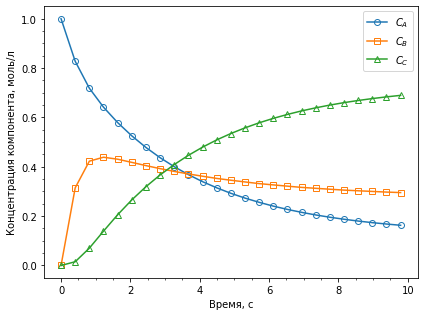

In [38]:
# plt.style.use('classic')

fig, ax = plt.subplots(figsize=(6, 4.5))

every = 2
ax.plot(t[::every], ca[::every], label=r'$C_A$', marker='o', fillstyle='none')
ax.plot(t[::every], cb[::every], label=r'$C_B$', marker='s', fillstyle='none')
ax.plot(t[::every], cc[::every], label=r'$C_C$', marker='^', fillstyle='none')

# ax.scatter(t, ca_old, label=r'$C_A$ old')
# ax.scatter(t, cb_old, label=r'$C_B$ old')
# ax.scatter(t, cc_old, label=r'$C_C$ old')

ax.set_xlabel('Время, с')
ax.set_ylabel('Концентрация компонента, моль/л')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.legend()

plt.tight_layout()
plt.savefig(r'..\pics\fig.pdf')

## Optimization

In [41]:
def obj_func(
    k: np.ndarray, c: np.ndarray,
    kinetic_scheme: callable,
    time: float,
    c0: np.ndarray,
    stoich_matrix: np.ndarray,
) -> float:
    solution = solve_ivp(
        fun=kinetic_by_matrix,
        t_span=(0, time[-1]),
        y0=c0   ,
        dense_output=True,
        args=(stoich_matrix, k)
    )

    c_calc = solution.sol(time[-1])
    return ((c - c_calc) ** 2).sum()

In [42]:
from scipy.optimize import minimize

In [50]:
c = np.array([.1606, .2945, .6922])
c0 = np.array([1, 0, 0])
time = np.linspace(0, 10, 50)
stoich_matrix = np.array([[-1, 2, 0], [1, -2, 0], [0, -2, 1], [0, 2, -1]])

initial_k = (.5, .5, .5, .5)
k = minimize(
    obj_func, 
    x0=initial_k, 
    args=(
        c, 
        kinetic_by_matrix,
        time,
        c0,
        stoich_matrix
    ),
    method='Nelder-Mead'
)
print(k)

 final_simplex: (array([[0.40298608, 0.56866624, 0.80859594, 0.07419382],
       [0.40291713, 0.56867713, 0.80862377, 0.07417934],
       [0.40290911, 0.56866281, 0.80862946, 0.07418973],
       [0.40300475, 0.56866888, 0.80856544, 0.07421872],
       [0.40295754, 0.56867751, 0.80859871, 0.07417644]]), array([1.61244305e-09, 1.63992065e-09, 1.65274699e-09, 2.05524296e-09,
       2.06513227e-09]))
           fun: 1.612443051432878e-09
       message: 'Optimization terminated successfully.'
          nfev: 142
           nit: 77
        status: 0
       success: True
             x: array([0.40298608, 0.56866624, 0.80859594, 0.07419382])


In [51]:
import genetic_algorithm as ga

In [55]:
bounds = ((.05, 1), (.05, 1), (.05, 1), (.05, 1))
k = ga.genetic_algorithm(
    bounds,
    obj_func,
    args=(
        c, 
        kinetic_by_matrix,
        time,
        c0,
        stoich_matrix
    ),
    popsize=100,
    selection_size=20,
    generations_count=10
)
print(k[0])

[0.5221326229161222, 0.7950758008292743, 0.8293744138383334, 0.08219397763058496]


In [57]:
initial_k = [
    0.5221326229161222, 0.7950758008292743, 
    0.8293744138383334, 0.08219397763058496
]
k = minimize(
    obj_func, 
    x0=initial_k, 
    args=(
        c, 
        kinetic_by_matrix,
        time,
        c0,
        stoich_matrix
    ),
    method='Nelder-Mead'
)
print(k)

 final_simplex: (array([[0.51709669, 0.81808365, 0.83553017, 0.08311357],
       [0.51713805, 0.81815404, 0.83548288, 0.08311136],
       [0.51711343, 0.81803742, 0.83551075, 0.08311706],
       [0.51706307, 0.81800744, 0.83555168, 0.08312275],
       [0.51711475, 0.81804012, 0.835535  , 0.08311974]]), array([1.14057758e-09, 1.14544246e-09, 1.17218242e-09, 1.21210320e-09,
       1.21655242e-09]))
           fun: 1.1405775778538453e-09
       message: 'Optimization terminated successfully.'
          nfev: 85
           nit: 43
        status: 0
       success: True
             x: array([0.51709669, 0.81808365, 0.83553017, 0.08311357])
